# Analyse de la Variance des Réponses LLM en fonction de la Température

Ce notebook a pour objectif d'analyser l'impact du paramètre `temperature` sur la **diversité** des réponses d'un modèle de langage (LLM). Nous allons :
1.  Définir une requête unique.
2.  Interroger un LLM compatible OpenAI **plusieurs fois** pour différentes valeurs de température.
3.  Stocker les réponses dans une base de données SQLite.
4.  Calculer la **variance intra-température** : pour chaque température, nous mesurons à quel point les réponses diffèrent les unes des autres.
5.  Visualiser cette variance sous forme de courbe pour observer la tendance.

In [ ]:
# 1. Importation des bibliothèques nécessaires
import os
import sqlite3
from datetime import datetime

import numpy as np
from dotenv import load_dotenv
from openai import OpenAI

# Charger les variables d'environnement du fichier .env
load_dotenv()

True

In [ ]:
# 2. Configuration

# --- Paramètres de la base de données ---
DB_FILE = "temperature_analysis.db"
TABLE_NAME = "llm_responses"

# --- Paramètres du LLM ---
# Assurez-vous que les variables API_KEY_OPENAI et BASE_URL_OPENAI sont dans votre .env
client = OpenAI(
    api_key=os.getenv("API_KEY_OPENAI"),
    base_url=os.getenv("BASE_URL_OPENAI"),
)
MODELE = os.getenv("MODELE_OPENAI", "gpt-4")

# --- Paramètres de l'expérience ---
# La requête à envoyer au LLM
QUERY = "Raconte une courte histoire de science-fiction sur un robot jardinier qui se prend d'amitié pour une fleur rare."

# Paramètres pour générer les températures à tester
TEMP_MIN = 0.0
TEMP_MAX = 1
TEMP_STEP = 0.1
TEMPERATURES = np.arange(TEMP_MIN, TEMP_MAX + TEMP_STEP, TEMP_STEP)

# Nombre d'appels à effectuer pour chaque température
CALLS_PER_TEMP = 10

print(f"Utilisation du modèle : {MODELE}")
print(f"Températures à tester : {TEMPERATURES}")
print(f"Nombre d'appels par température : {CALLS_PER_TEMP}")

Utilisation du modèle : devstral
Températures à tester : [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]
Nombre d'appels par température : 5


In [3]:
# 3. Initialisation de la base de données


def setup_database():
    """Crée la table pour stocker les réponses si elle n'existe pas."""
    with sqlite3.connect(DB_FILE) as conn:
        cursor = conn.cursor()
        cursor.execute(f"""
        CREATE TABLE IF NOT EXISTS {TABLE_NAME} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            temperature REAL NOT NULL,
            call_number INTEGER NOT NULL,
            response_text TEXT NOT NULL,
            generated_at TIMESTAMP NOT NULL
        )
        """)
        # Vider la table pour une nouvelle exécution
        cursor.execute(f"DELETE FROM {TABLE_NAME}")
        print(
            f"Base de données '{DB_FILE}' et table '{TABLE_NAME}' prêtes. Table vidée pour la nouvelle exécution."
        )
        conn.commit()


setup_database()

Base de données 'temperature_analysis.db' et table 'llm_responses' prêtes. Table vidée pour la nouvelle exécution.


In [4]:
# 4. Génération et stockage des réponses


def generate_and_store_responses():
    """Itère sur les températures, appelle le LLM plusieurs fois pour chacune et stocke les réponses."""
    with sqlite3.connect(DB_FILE) as conn:
        cursor = conn.cursor()

        for temp in TEMPERATURES:
            for i in range(CALLS_PER_TEMP):
                print(
                    f"Génération de la réponse pour température={temp}, appel n°{i + 1}/{CALLS_PER_TEMP}..."
                )
                try:
                    response = client.chat.completions.create(
                        model=MODELE,
                        messages=[{"role": "user", "content": QUERY}],
                        temperature=temp,
                    )
                    content = response.choices[0].message.content

                    # Insérer la réponse dans la base de données
                    cursor.execute(
                        f"INSERT INTO {TABLE_NAME} (temperature, call_number, response_text, generated_at) VALUES (?, ?, ?, ?)",
                        (temp, i + 1, content, datetime.now()),
                    )
                    conn.commit()
                    print(f"Réponse stockée.")

                except Exception as e:
                    print(
                        f"Erreur lors de l'appel au LLM pour la température {temp}: {e}"
                    )


generate_and_store_responses()
print("\nToutes les réponses ont été générées et stockées.")

Génération de la réponse pour température=0.0, appel n°1/5...


C:\Users\beranger\AppData\Local\Temp\ipykernel_7416\1928246133.py:23: DeprecationWarning: The default datetime adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  cursor.execute(


Réponse stockée.
Génération de la réponse pour température=0.0, appel n°2/5...
Réponse stockée.
Génération de la réponse pour température=0.0, appel n°3/5...
Réponse stockée.
Génération de la réponse pour température=0.0, appel n°3/5...
Réponse stockée.
Génération de la réponse pour température=0.0, appel n°4/5...
Réponse stockée.
Génération de la réponse pour température=0.0, appel n°4/5...
Réponse stockée.
Génération de la réponse pour température=0.0, appel n°5/5...
Réponse stockée.
Génération de la réponse pour température=0.0, appel n°5/5...
Réponse stockée.
Génération de la réponse pour température=0.2, appel n°1/5...
Réponse stockée.
Génération de la réponse pour température=0.2, appel n°1/5...
Réponse stockée.
Génération de la réponse pour température=0.2, appel n°2/5...
Réponse stockée.
Génération de la réponse pour température=0.2, appel n°2/5...
Réponse stockée.
Génération de la réponse pour température=0.2, appel n°3/5...
Réponse stockée.
Génération de la réponse pour tempé

Tableau des différentes métriques de variance par température :
   temperature  variance  lexical_entropy  length_variance  \
0          0.0  0.182825         7.561167     5.953600e+02   
1          0.2  0.947182         8.240252     8.860136e+04   
2          0.4  0.928696         8.277754     2.947304e+04   
3          0.6  0.942039         8.340543     7.485496e+04   
4          0.8  0.954039         8.499482     9.809504e+04   
5          1.0  0.949533         8.559353     8.359520e+04   
6          1.2  0.963930         9.038852     2.046888e+05   
7          1.4  0.965457         9.013337     1.143415e+06   

   length_variance_normalized  
0                    0.000521  
1                    0.077488  
2                    0.025776  
3                    0.065466  
4                    0.085791  
5                    0.073110  
6                    0.179015  
7                    1.000000  


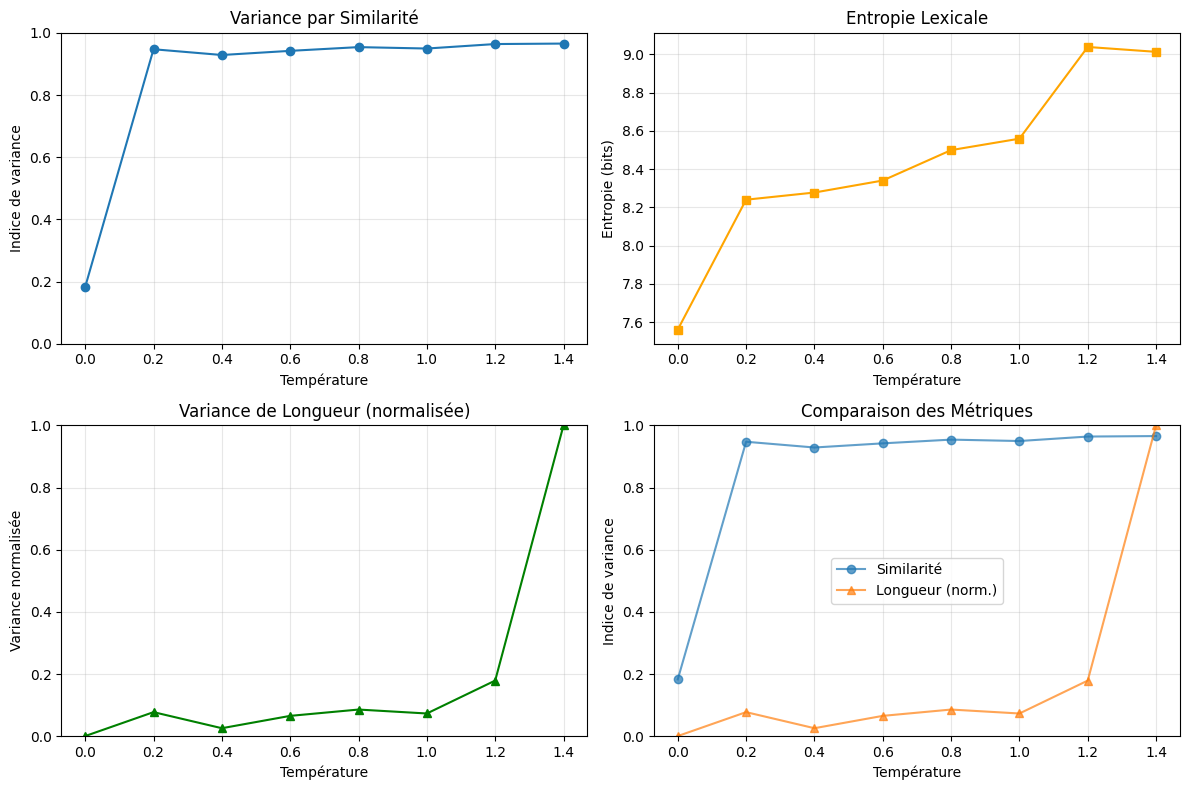

In [ ]:
from collections import Counter
import math

# 5. Analyse alternative de la variance : calcul de l'entropie lexicale


def calculate_lexical_entropy(responses):
    """Calcule l'entropie lexicale pour mesurer la diversité du vocabulaire."""
    if len(responses) < 2:
        return 0.0

    # Concaténer toutes les réponses et extraire les mots
    all_text = " ".join(responses).lower()
    words = all_text.split()

    # Compter la fréquence des mots
    word_counts = Counter(words)
    total_words = len(words)

    # Calculer l'entropie
    entropy = 0
    for count in word_counts.values():
        probability = count / total_words
        entropy -= probability * math.log2(probability)

    return entropy


def calculate_length_variance(responses):
    """Calcule la variance de la longueur des réponses."""
    if len(responses) < 2:
        return 0.0

    lengths = [len(response) for response in responses]
    mean_length = sum(lengths) / len(lengths)
    variance = sum((length - mean_length) ** 2 for length in lengths) / len(lengths)

    return variance


# Calculer les nouvelles métriques de variance
entropy_results = df.groupby("temperature")["response_text"].apply(
    lambda x: calculate_lexical_entropy(list(x))
)
length_variance_results = df.groupby("temperature")["response_text"].apply(
    lambda x: calculate_length_variance(list(x))
)

# Créer un DataFrame combiné avec toutes les métriques
combined_variance_df = variance_df.copy()
combined_variance_df["lexical_entropy"] = entropy_results.values
combined_variance_df["length_variance"] = length_variance_results.values

# Normaliser la variance de longueur pour la visualisation
max_length_var = combined_variance_df["length_variance"].max()
if max_length_var > 0:
    combined_variance_df["length_variance_normalized"] = (
        combined_variance_df["length_variance"] / max_length_var
    )
else:
    combined_variance_df["length_variance_normalized"] = 0

print("Tableau des différentes métriques de variance par température :")
print(combined_variance_df)

# Visualisation comparative des différentes métriques
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(
    combined_variance_df["temperature"],
    combined_variance_df["variance"],
    "o-",
    label="Variance par similarité",
)
plt.title("Variance par Similarité")
plt.xlabel("Température")
plt.ylabel("Indice de variance")
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.subplot(2, 2, 2)
plt.plot(
    combined_variance_df["temperature"],
    combined_variance_df["lexical_entropy"],
    "s-",
    color="orange",
    label="Entropie lexicale",
)
plt.title("Entropie Lexicale")
plt.xlabel("Température")
plt.ylabel("Entropie (bits)")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(
    combined_variance_df["temperature"],
    combined_variance_df["length_variance_normalized"],
    "^-",
    color="green",
    label="Variance de longueur",
)
plt.title("Variance de Longueur (normalisée)")
plt.xlabel("Température")
plt.ylabel("Variance normalisée")
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.subplot(2, 2, 4)
plt.plot(
    combined_variance_df["temperature"],
    combined_variance_df["variance"],
    "o-",
    label="Similarité",
    alpha=0.7,
)
plt.plot(
    combined_variance_df["temperature"],
    combined_variance_df["length_variance_normalized"],
    "^-",
    label="Longueur (norm.)",
    alpha=0.7,
)
plt.title("Comparaison des Métriques")
plt.xlabel("Température")
plt.ylabel("Indice de variance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Conclusion

La courbe ci-dessus illustre la variance des réponses pour une même température.

- **À basse température (proche de 0.0)**, la variance est nulle ou quasi-nulle. Le modèle est déterministe et produit des réponses identiques à chaque appel.
- **À mesure que la température augmente**, la variance tend à croître. Cela signifie que pour une même requête, le modèle génère des réponses de plus en plus différentes les unes des autres. La "créativité" et la diversité des sorties augmentent.
- **À très haute température**, la variance peut atteindre un plateau. Les réponses deviennent très diverses, parfois au détriment de la cohérence.

Cette expérience montre comment la température peut être utilisée pour ajuster la consistance des réponses du LLM. Une température basse garantit la reproductibilité, tandis qu'une température élevée favorise l'originalité et la surprise.